In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rc
from scipy.signal import find_peaks 
from cProfile import label
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sympy import *

In [2]:
def conc(m, M, V):
  c = m/(M*V)
  return c

def epsilon(A, c_list):
  eps_df = pd.DataFrame()
  eps_df['wavelength'] = A['wavelength']
  for i, key in enumerate(A.keys()[1:]):
    c = c_list[i]
    eps = A[key]/c
    eps_df[key] = eps
  return eps_df

def diff_epsilon(A_hcl, c_hcl, A_h2o, c_h2o):
  diff = epsilon(A_hcl, c_hcl) - epsilon(A_h2o, c_h2o)
  return diff

def cross_section(c_list, A):
  sigma_df = []
  keys = list(A.keys())
  for i in range(len(keys)):
    c = c_list[i]
    n=(6.022*10**23)*(c/1000) #c is in mol/L so the divirion by 1000 is conversion from L to cm**3
    sigma=A[keys[i]]/n #l is not included since it is equal to 1cm
    sigma_df.append(sigma)
  new_df = pd.concat(sigma_df, axis = 1)
  return new_df

In [3]:

M_NaCl = 58.44 #g/mol
M_MnCl2 = 197.91 #g/mol
cStart_array = np.array([3.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1]) #mol/L
V_NaCl = np.full(7, 0.01) #L
V_pH = np.array([0.05, 0.05, 0.10, 0.05, 0.10, 0.10]) #L

mStart_array = M_NaCl*cStart_array*V_NaCl
print(mStart_array)

m_NaCl = np.array([1.692, 0.882, 0.587, 0.439, 0.342, 0.149, 0.074]) #g
m_MnCl2 = np.array([16.059, 16.139, 17.683, 8.668, 0.0093, 0.0102]) #g

c_NaCl = conc(m_NaCl, M_NaCl, V_NaCl)
c_MnCl2 = conc(m_MnCl2, M_MnCl2, V_pH)
c_MnCl2_forNaCl = [c_MnCl2[2], c_MnCl2[2], c_MnCl2[2], c_MnCl2[2], c_MnCl2[2], c_MnCl2[2], c_MnCl2[2]]
print(c_NaCl)
print(c_MnCl2)

[1.7532  0.8766  0.5844  0.4383  0.2922  0.1461  0.05844]
[2.89527721 1.50924025 1.00444901 0.75119781 0.58521561 0.25496235
 0.1266256 ]
[1.62285888e+00 1.63094336e+00 8.93486939e-01 8.75953716e-01
 4.69910565e-04 5.15385781e-04]


In [4]:
MnCl2_pH_path = "./mncl2_ph.CSV"
MnCl2_pH=pd.read_csv(MnCl2_pH_path, sep=';', decimal=',')
MnCl2_pH = MnCl2_pH.drop(['hcl'], axis = 1)
# display(MnCl2_pH)

diff_path = './difference_solvent.CSV'
diff_solv = pd.read_csv(diff_path, sep = ';', decimal = ',')

MnCl2_NaCl_path = "./mncl2_wnacl.CSV"
MnCl2_NaCl=pd.read_csv(MnCl2_NaCl_path, sep=';', decimal=',')
# display(MnCl2_NaCl)

In [5]:
eps_fRep = epsilon(MnCl2_pH, c_MnCl2)
eps_fRep.to_csv('epsilon_fRep.csv')
eps_fRep_short = eps_fRep.drop(['s5.3', 's6.3'], axis=1)

eps_MnCl2_NaCl = epsilon(MnCl2_NaCl, c_MnCl2_forNaCl)
eps_MnCl2_NaCl.to_csv('epsilon_MnCl2_NaCl.csv')

display(eps_MnCl2_NaCl)

,wavelength,s1.4,s2.4,s3.4,s4.4,s5.4,s6.4,s7.4
0,200.0,2.506360,2.428463,2.484424,2.463047,2.480394,2.409325,2.450623
1,200.1,2.510613,2.433723,2.486326,2.443237,2.481066,2.413354,2.446930
2,200.2,2.508263,2.443796,2.490355,2.440662,2.481066,2.413354,2.435402
3,200.3,2.503002,2.446482,2.495392,2.424098,2.485207,2.416264,2.433276
4,200.4,2.495168,2.456331,2.500652,2.431933,2.492930,2.425329,2.427792
...,...,...,...,...,...,...,...,...
6996,899.6,-0.003358,0.000112,-0.000895,0.000000,0.001903,0.000672,0.000672
6997,899.7,-0.003134,0.000336,0.001007,-0.000448,0.003134,0.000672,0.001567
6998,899.8,-0.002798,0.000560,0.002015,0.000224,0.003470,0.001231,0.002798
6999,899.9,-0.003581,-0.000112,0.001903,-0.000783,0.004365,0.000895,0.003693


In [6]:
fRep_labels = ['1.62 M in water', '1.63 M in HCl', '8.93$\cdot$10$^{-1}$ M in water', '8.76$\cdot$10$^{-1}$ M in HCl', 
               '4.70$\cdot$10$^{-4}$ M in water', '5.15$\cdot$10$^{-4}$ M in HCl']
fRep_labels_short = ['1.62 M in water', '1.63 M in HCl', '8.93$\cdot$10$^{-1}$ M in water', '8.76$\cdot$10$^{-1}$ M in HCl']
wNaCl_labels = ['2.90 M', '1.51 M', '1.00 M', '7.51$\cdot$10$^{-1}$ M', '5.85$\cdot$10$^{-1}$ M', '2.55$\cdot$10$^{-1}$ M', 
                '1.27$\cdot$10$^{-1}$ M']

In [19]:
def plot_with_inset(ax, df, labels_list, lbl_title):
    for i, key in enumerate(df.keys()[1:]):
        ax.plot(df['wavelength'], df[key], lw = 1, label = labels_list[i])

    ax.set_ylabel('Molar absorption \n coefficient / M$^{-1}$cm$^{-1}$', fontsize = 8)
    ax.set_xlabel('Wavelength / nm', fontsize = 8)

    ax.set_xlim(200, 900)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

    ax.legend(frameon = False, fontsize = 8, loc = 2, 
            bbox_to_anchor = (0.06, 1), title = lbl_title, title_fontsize = 8)
    # loc = 2, bbox_to_anchor = (0.05, 0.95), ncol = 1      Upper left corner
    # loc = 2, bbox_to_anchor = (0.07, 0.3), ncol = 2       Lower left corner
    # loc = 2, bbox_to_achor = (0.23, 0.33), ncol = 2       Bottom center
    # loc = 4, bbox_to_anchor = (1,1), ncol = 3             On top of figure

    inset_ax = inset_axes(ax,
                        width="40%", # width = % of parent_bbox
                        height=0.8, # height : 1 inch
                        bbox_to_anchor=(0, 0, 0.97, 0.95),
                        bbox_transform=ax.transAxes) # placement in figure

    for key in df.keys()[1:]:
        inset_ax.plot(df['wavelength'], df[key], lw = 1) 

    inset_ax.set_ylabel(None)
    inset_ax.set_xlabel(None)
    inset_ax.set_ylim(0, 0.05)
    inset_ax.set_xlim(200, 600)

    inset_ax.xaxis.set_minor_locator(AutoMinorLocator())
    inset_ax.yaxis.set_minor_locator(AutoMinorLocator())
    inset_ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    inset_ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    # plt.xticks(rotation = 45, ha = 'right')

    inset_ax.legend().set_visible(False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\nan25\AppData\Local\Temp\ipykernel_11700\98564548.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


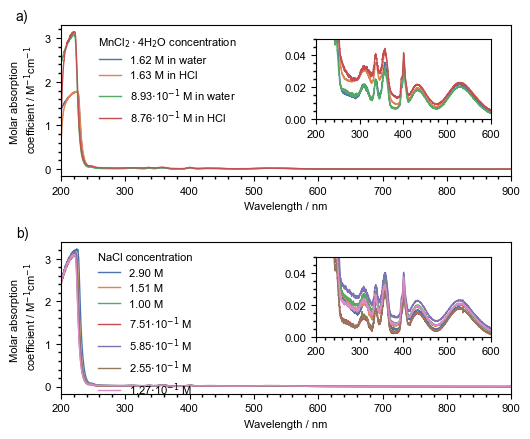

In [20]:
fig, ax = plt.subplots(2,1, figsize = (5.5, 4.5))

plot_with_inset(ax[0], eps_fRep_short, fRep_labels_short, 'MnCl$_{2}\cdot$4H$_{2}$O concentration')
plot_with_inset(ax[1], eps_MnCl2_NaCl, wNaCl_labels, 'NaCl concentration')

sublabels = ['a)', 'b)']
for ax, l in zip(ax.flatten(), sublabels):
    ax.text(-0.1, 1.03, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('full_uvvis.jpg', dpi=600)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


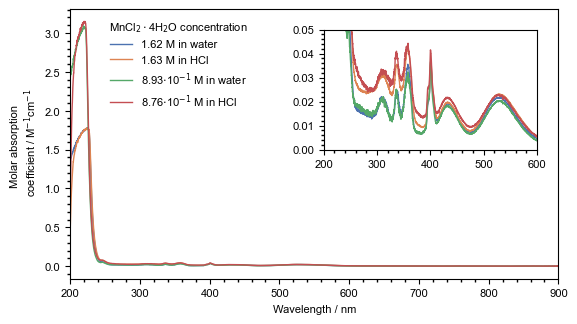

In [11]:
fig, ax = plt.subplots( figsize = (6.3, 3.5))

plot_with_inset(ax, eps_fRep_short, fRep_labels_short, 'MnCl$_{2}\cdot$4H$_{2}$O concentration')

plt.savefig('eps_fRep_full_1-4.png', dpi=150)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


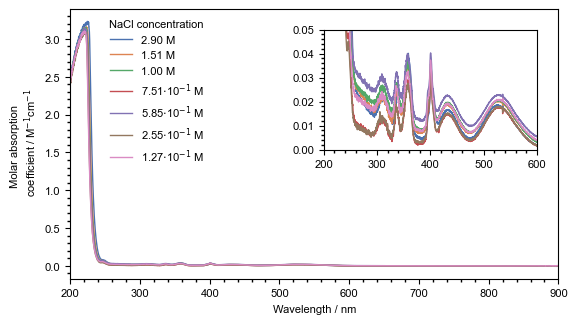

In [12]:
fig, ax = plt.subplots(figsize = (6.3, 3.5))

plot_with_inset(ax, eps_MnCl2_NaCl, wNaCl_labels, 'NaCl concentration')

plt.savefig('eps_wNaCl_full.png', dpi=150)
plt.show()